In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_pickle('../../../cooked_data/caluire_2011_2021_monthly.pickle')
result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)

In [44]:
def predict(df, length):
    '''
    Input:
    - time serie                          (pd.serie)
    - forecast length in months           (int)
    
    It performs an ARIMA prediction of the time series for the next 'length' months.
    
    Returns:
    - deseasonalized and linearized serie (pd serie)
    - forecast serie                      (pd serie)
    - std_err                             (np.ndarray) 
    - confidence interval serie           (np.ndarray)
    - forecast length in months           (np.ndarray)
    '''
    result_mul = seasonal_decompose(df['1340'], model = 'multiplicative', period = 12)

    df['deseasonalized'] = df['1340'].values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])

    train = df['linearized']
    p, d, q = 3, 1, 2
    
    arima = ARIMA(train, order=(p,d,q)).fit()
    forecast, std_err, confidence_int = arima.forecast(length, alpha=0.05)
    forecast = np.exp(forecast)*result_mul.seasonal[-length:]
    train = np.exp(train)*result_mul.seasonal
    lower = np.exp(confidence_int)[:,0]*result_mul.seasonal[-length:]
    upper = np.exp(confidence_int)[:,1]*result_mul.seasonal[-length:]
    return train, forecast, std_err, confidence_int, length

In [16]:
fore_12 = predict(df, 12)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96652D-02    |proj g|=  7.27421D+00

At iterate    5    f= -7.54698D-02    |proj g|=  8.88865D-02

At iterate   10    f= -7.56910D-02    |proj g|=  1.23953D+00

At iterate   15    f= -7.64437D-02    |proj g|=  2.52713D-03

At iterate   20    f= -7.64943D-02    |proj g|=  4.29437D-03

At iterate   25    f= -7.65315D-02    |proj g|=  1.36074D-01

At iterate   30    f= -7.65571D-02    |proj g|=  3.83087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [26]:
forecast = fore_12[1]
train = fore_12[0]
upper = fore_12[3][:,0]
lower = fore_12[3][:,1]
confidence_int = fore_12[3]
length = fore_12[4]

In [27]:
print(type(forecast))
print(type(train))
print(type(upper))
print(type(lower))
print(type(confidence_int))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [30]:
def plot_forecast(train, length, fc, upper=None, lower=None):
    index = train.index[-length:] + train.index.freq*length
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=index)
    lower_series = pd.Series(upper, index=index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

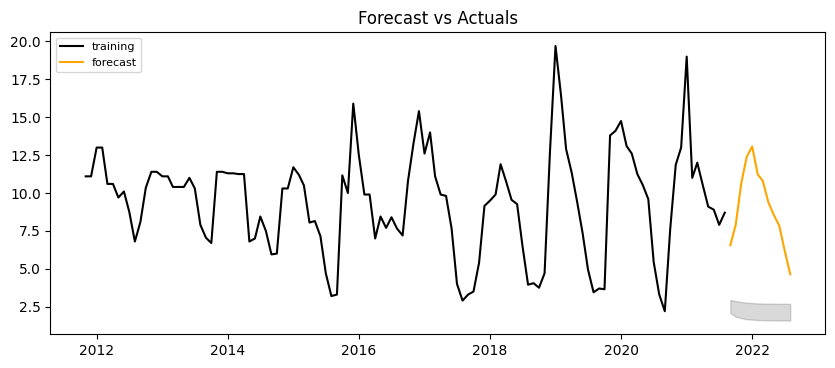

In [31]:
plot_forecast(train, length, forecast.values, lower, upper)

In [42]:
def plot_24(train, length, fc, upper=None, lower=None):
    
    train = train[-24:]
    index = train.index[-length:] + train.index.freq*length
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    
    fc_series = pd.Series(fc, index = index)
    lower_series = pd.Series(upper, index = index) if is_confidence_int else None
    upper_series = pd.Series(lower, index = index) if is_confidence_int else None
    
    plt.figure(figsize = (10,4), dpi = 100)
    plt.plot(train, label = f'Nitrates concentration of last 24 months', color = 'black')
    plt.plot(fc_series, label = 'Forecast', color = 'orange', ls = '--')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.15)
    plt.title(f'Forecast for the next {length} months')
    plt.legend(loc = 'upper left', fontsize = 8)    

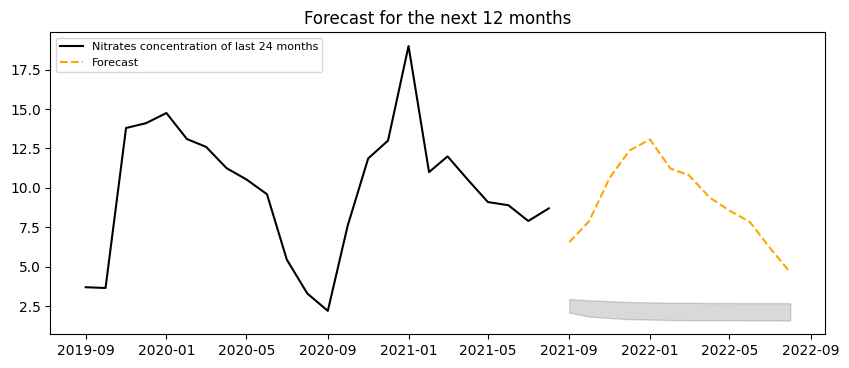

In [43]:
plot_24(train, length, forecast.values, lower, upper)